In [1]:
import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model, Model, save_model
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv3D, Conv2D, Conv1D, Dropout, MaxPooling2D, LeakyReLU, BatchNormalization, Reshape, InputLayer, Input, ZeroPadding3D, ZeroPadding2D, UpSampling2D, UpSampling3D, MaxPool3D, MaxPooling3D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from matplotlib import pyplot
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
import sys

NUM_FRAMES = 10
RESOLUTION = 32
CHANNELS = 1

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
# example of horizontal shift image augmentation
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image

def load_dataset():    
    # Download and load the dataset.
    fpath = keras.utils.get_file(
        "moving_mnist.npy",
        "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
    )
    dataset = np.load(fpath)    
    dataset = np.swapaxes(dataset, 0, 1)
    dataset = np.expand_dims(dataset, 4)    
    dataset = dataset[:, :, ::2, ::2, :]  
    return dataset

dataset_20 = load_dataset()
dataset0 = dataset_20[:, :10, ...]
dataset1 = dataset_20[:, 10:, ...]
print(dataset0.shape)
dataset = np.concatenate((dataset0, dataset1))
print(dataset.shape)
# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.seed(42)
np.random.shuffle(indexes)
train_index = indexes[: int(0.8 * dataset.shape[0])]
val_index = indexes[int(0.8 * dataset.shape[0]) : int(0.95 * dataset.shape[0])]
test_index = indexes[int(0.95 * dataset.shape[0]) :]

train_dataset = dataset[train_index] / 255.
val_dataset = dataset[val_index] / 255.
test_dataset = dataset[test_index] / 255.

print("Train data: ", train_dataset.shape)

(10000, 10, 32, 32, 1)
(20000, 10, 32, 32, 1)
Train data:  (16000, 10, 32, 32, 1)


In [4]:
y_train = train_dataset
x_train = np.array(train_dataset)
x_train[:, 1:9, :, :, :] = 0

y_val = val_dataset
x_val = np.array(val_dataset)
x_val[:, 1:9, :, :, :] = 0

y_test = test_dataset
x_test = np.array(test_dataset)
x_test[:, 1:9, :, :, :] = 0

In [5]:
def display_img(img):
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))        
    ax.imshow(img, cmap='gray')

def display_seq(data, label=''):
    fig, axes = plt.subplots(1, 10, figsize=(25, 5))
    ax = axes.flatten()    
    for i, frame in enumerate(data): 
        if i >= 10:
            break
        ax[i].set_title(f"{label} {i}", fontsize=32)
        ax[i].imshow(frame, cmap='gray', vmin=0., vmax=1.)            
        ax[i].axis("off")

In [6]:
img_shape = x_train[0].shape
print(img_shape)
def create_model():
    inp = layers.Input(shape=(img_shape))
    print(inp)
    # create model    
    model = Sequential()
    model.add(layers.ConvLSTM2D(
            filters=64,
            kernel_size=(1, 1),
            padding="same",
            return_sequences=True,
            activation="relu"
        ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(.5))
    model.add(layers.ConvLSTM2D(
            filters=64,
            kernel_size=(1, 1),
            padding="same",
            return_sequences=True,
            activation="relu"
        ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(.5))
    model.add(layers.ConvLSTM2D(
                filters=64,
                kernel_size=(1, 1),
                padding="same",
                return_sequences=True,
                activation="relu"
            ))
    model.add(layers.Conv3D(
                filters=1, kernel_size=(3, 3, 3), activation=keras.activations.tanh, padding="same"
            ))        
        
    model.compile(
        loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Nadam(),
    )
    model.build(inp.shape)
    # summarize model
    model.summary(line_length=100, expand_nested=True, show_trainable=False)
    return model

model = create_model()

(10, 32, 32, 1)
KerasTensor(type_spec=TensorSpec(shape=(None, 10, 32, 32, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv_lstm2d (ConvLSTM2D)                    (None, 10, 32, 32, 64)                  16896          
                                                                                                    
 batch_normalization (BatchNormalization)    (None, 10, 32, 32, 64)                  256            
                                                                                                    
 dropout (Dropout)                           (None, 10, 32, 32, 64)                  0              
                                                                                                    
 

In [7]:
## Model Training
#With our model and data constructed, we can now train the model.
import time
start_time = time.time()

# Define some callbacks to improve training.
checkpoint_filepath = './savedModels/Keras_ConvLSTM_6_nonRecursive_relu.h5'
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2)
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor="val_loss", save_best_only=True)

# Define modifiable training hyperparameters.
epochs = 100
batch_size = 64
print(x_train.shape)
# Fit the model to the training data.
model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val, y_val),callbacks=[early_stopping, reduce_lr, model_checkpoint])

print("--- %s seconds ---" % (time.time() - start_time))

(16000, 10, 32, 32, 1)
Epoch 1/100


2022-06-30 22:14:25.538039: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/sequential/conv_lstm2d_2/while/sequential/conv_lstm2d_2/while_grad/body/_555/input/_1530' -> 'gradient_tape/sequential/conv_lstm2d_2/while/sequential/conv_lstm2d_2/while_grad/body/_555/gradient_tape/sequential/conv_lstm2d_2/while/gradients/AddN', 'sequential/conv_lstm2d_2/while/body/_367/sequential/conv_lstm2d_2/while/mul_2' -> 'sequential/conv_lstm2d_2/while/body/_367/sequential/conv_lstm2d_2/while/add_5', 'sequential/conv_lstm2d_2/while/body/_367/sequential/conv_lstm2d_2/while/clip_by_value' -> 'sequential/conv_lstm2d_2/while/body/_367/sequential/conv_lstm2d_2/while/mul_3', 'sequential/conv_lstm2d_2/while/body/_367/sequential/conv_lstm2d_2/while/convolution_6' -> 'sequential/conv_lstm2d_2/while/body/_367/sequential/conv_lstm2d_2/while/add_4', 'sequential/conv_lstm2d_

250/250 [==============================] - 116s 449ms/step - loss: 0.1630 - val_loss: 0.4653 - lr: 0.0010
Epoch 2/100
250/250 [==============================] - 113s 451ms/step - loss: 0.1430 - val_loss: 0.2055 - lr: 0.0010
Epoch 3/100
250/250 [==============================] - 113s 451ms/step - loss: 0.1387 - val_loss: 0.1440 - lr: 0.0010
Epoch 4/100
250/250 [==============================] - 113s 453ms/step - loss: 0.1379 - val_loss: 0.1397 - lr: 0.0010
Epoch 5/100
250/250 [==============================] - 114s 454ms/step - loss: 0.1375 - val_loss: 0.2341 - lr: 0.0010
Epoch 6/100
250/250 [==============================] - 114s 455ms/step - loss: 0.1363 - val_loss: 0.1355 - lr: 0.0010
Epoch 7/100
250/250 [==============================] - 114s 455ms/step - loss: 0.1357 - val_loss: 0.1356 - lr: 0.0010
Epoch 8/100
250/250 [==============================] - 114s 455ms/step - loss: 0.1365 - val_loss: 0.2258 - lr: 0.0010
Epoch 9/100
250/250 [==============================] - 114s 456ms/st

In [8]:
"""Epoch 29/100
250/250 [==============================] - 114s 457ms/step - loss: 0.1348 - val_loss: 0.1349 - lr: 1.0000e-06
--- 3306.8075692653656 seconds ---"""

'Epoch 29/100\n250/250 [==============================] - 114s 457ms/step - loss: 0.1348 - val_loss: 0.1349 - lr: 1.0000e-06\n--- 3306.8075692653656 seconds ---'

In [9]:
# Clamp images, else the predictions get very blurry
# theta: threshold to decide where to clip values
# epsilon: keep some values unclipped, to avoid too jagged edges
def clamp_image_array(y_hat, theta=.3, epsilon=.1):        
    y_hat_p = np.where(y_hat < theta - epsilon, 0, y_hat)
    y_hat_p = np.where(y_hat_p >= theta + epsilon, 1, y_hat_p)
    return y_hat_p

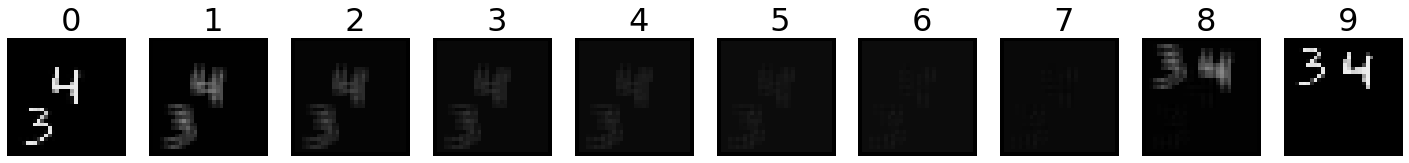

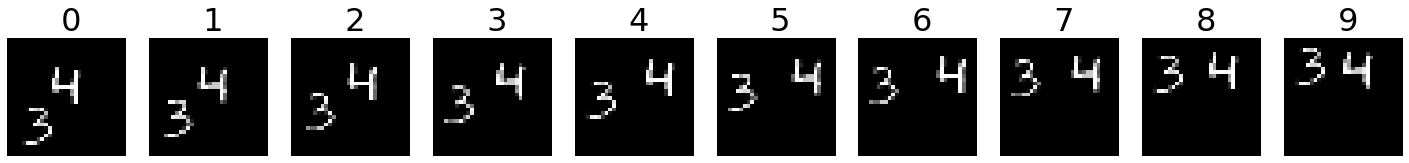

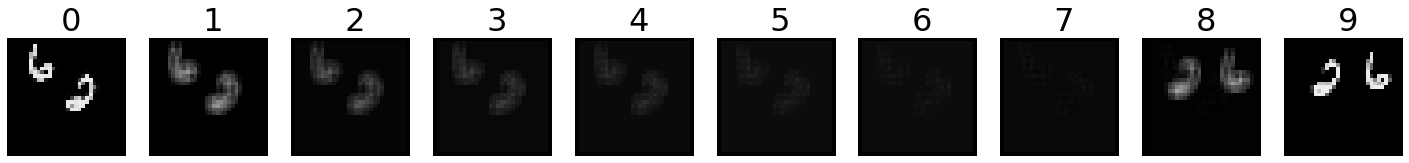

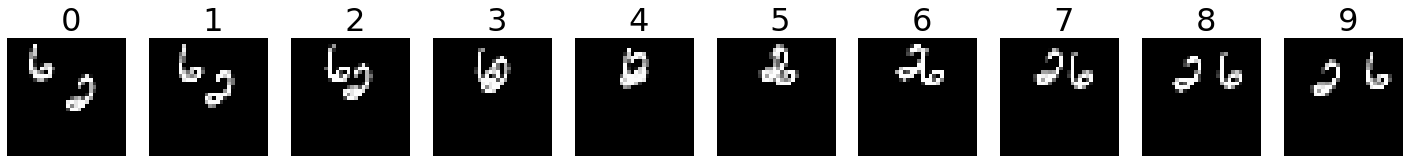

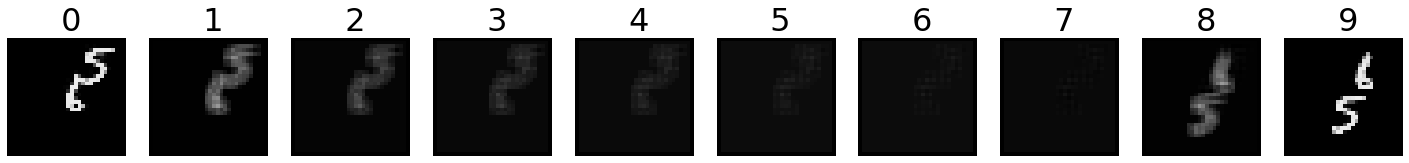

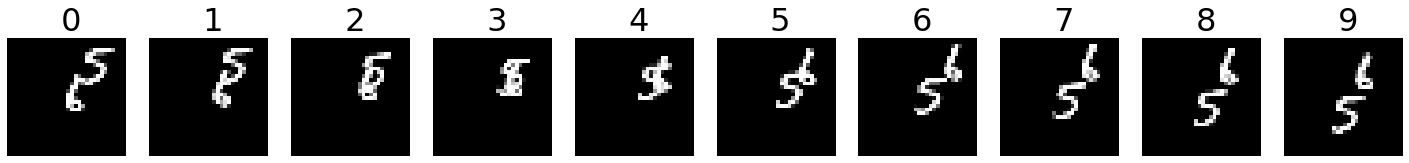

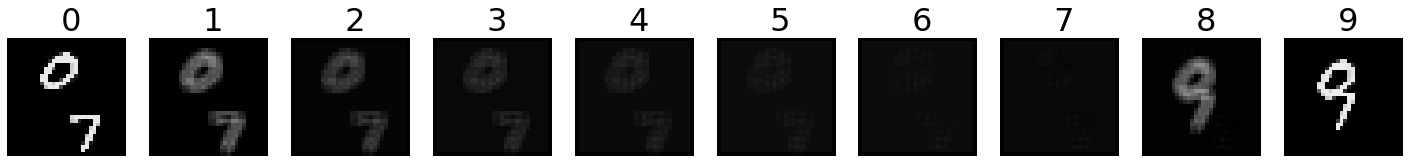

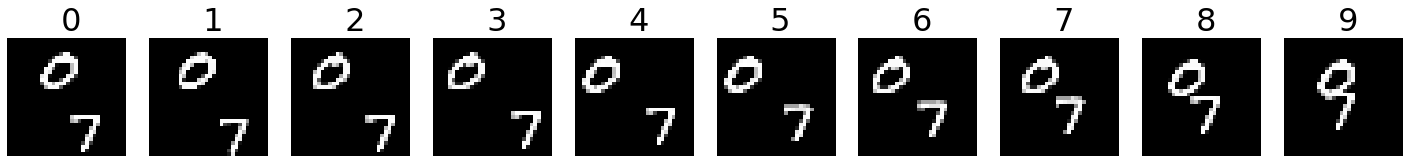

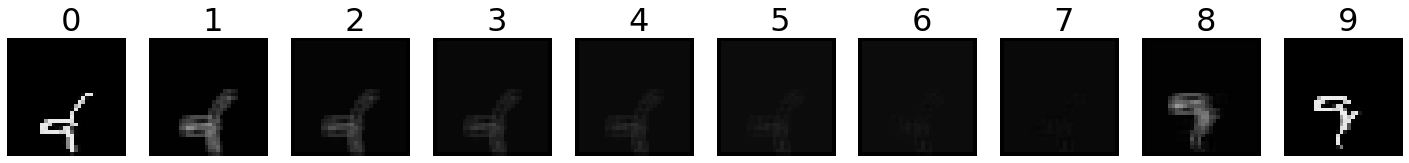

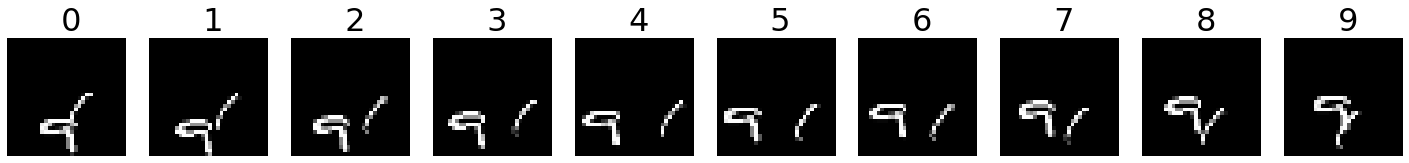

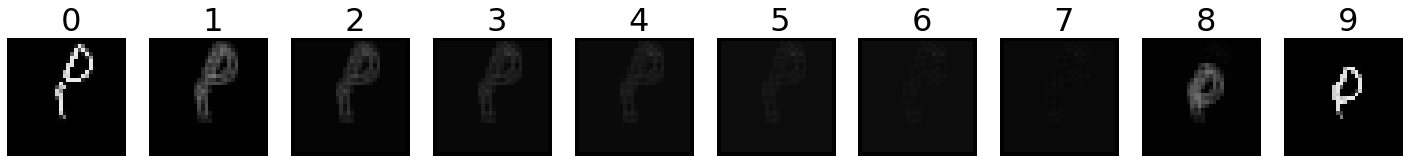

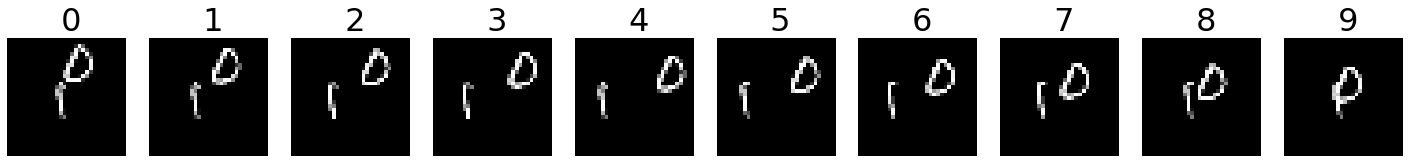

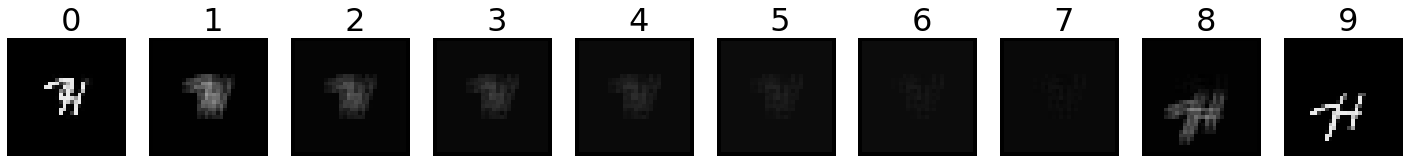

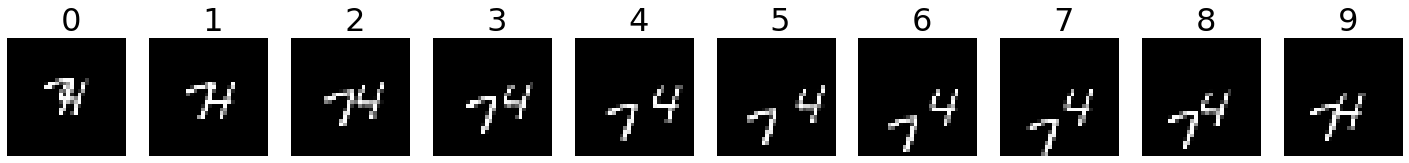

In [10]:
model = tf.keras.models.load_model(checkpoint_filepath)

good = [22, 44, 52, 64, 73, 76, 94]
for i in good:
    test_set = test_dataset[i, :, :, :, :]
    test_set = np.expand_dims(test_set, axis=0)
    y_test_set = np.array(test_set)
    x_test_set = np.array(test_set)
    x_test_set[:, 1:9, :, :, :] = 0
    
    yhat = model.predict(x_test_set)

    display_seq(yhat[0])
    #display_seq(clamp_image_array(yhat[0], theta=.35, epsilon=0.15))
    display_seq(y_test_set[0])